# Load CSV data in TF

Introduction on how to use CSV data with TensorFlow.

1. **Loading the data off disk**
2. **Pre-processing it into a form suitable for training.**

## Setup

In [2]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## In memory data

For any small CSV dataset the simplest way to train a TensorFlow model on it is to load it into memory as a pandas Dataframe or a NumPy array. 

A relatively simple example is the [abalone dataset]

* The dataset is small. 
* All the input features are all limited-range floating point values. 


In [3]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
           "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


The nominal task for this dataset is to predict the age from the other measurements, so separate the features and labels for training:


In [4]:
abalone_features = abalone_train.copy()
abalone_labels = abalone_features.pop('Age')

Treat all features identically. Pack the features into a single NumPy array.:

In [5]:
abalone_features = np.array(abalone_features)
abalone_features

array([[0.435, 0.335, 0.11 , ..., 0.136, 0.077, 0.097],
       [0.585, 0.45 , 0.125, ..., 0.354, 0.207, 0.225],
       [0.655, 0.51 , 0.16 , ..., 0.396, 0.282, 0.37 ],
       ...,
       [0.53 , 0.42 , 0.13 , ..., 0.374, 0.167, 0.249],
       [0.395, 0.315, 0.105, ..., 0.118, 0.091, 0.119],
       [0.45 , 0.355, 0.12 , ..., 0.115, 0.067, 0.16 ]])

Make a regression model predict the age. Since there is only a single input tensor, a `keras.Sequential` model is sufficient here.

In [6]:
abalone_model = tf.keras.Sequential([
  layers.Dense(64),
  layers.Dense(1)
])

abalone_model.compile(loss = tf.losses.MeanSquaredError(),
                      optimizer = tf.optimizers.Adam())

To train that model, pass the features and labels to `Model.fit`:

In [7]:
abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10
104/104 [==============================] - 10s 2ms/step - loss: 62.8223
Epoch 2/10
104/104 [==============================] - 0s 1ms/step - loss: 11.7930
Epoch 3/10
104/104 [==============================] - 4s 41ms/step - loss: 8.4208
Epoch 4/10
104/104 [==============================] - 0s 1ms/step - loss: 7.9564A: 0s - loss: 7.89
Epoch 5/10
104/104 [==============================] - 0s 1ms/step - loss: 7.5468
Epoch 6/10
104/104 [==============================] - 0s 1ms/step - loss: 7.1996
Epoch 7/10
104/104 [==============================] - 0s 1ms/step - loss: 6.9527
Epoch 8/10
104/104 [==============================] - 0s 1ms/step - loss: 6.7499
Epoch 9/10
104/104 [==============================] - 4s 37ms/step - loss: 6.6172
Epoch 10/10
104/104 [==============================] - 0s 1ms/step - loss: 6.5077


Next is about how to apply preprocessing to normalize numeric columns.

## Basic preprocessing

It's good practice to normalize the inputs before fed to model. The `experimental.preprocessing` layers provide a convenient way to build this normalization into the model. The layer will precompute the mean and variance of each column, and use these to normalize the data.

First step is to create the layer:

In [8]:
normalize = preprocessing.Normalization()

Then use the `Normalization.adapt()` method to adapt the normalization layer to the data.

Note: Only use training data to `.adapt()` preprocessing layers. Do not use validation or test data.

In [9]:
normalize.adapt(abalone_features)

Then use the normalization layer in the model:

In [10]:
norm_abalone_model = tf.keras.Sequential([
  normalize,
  layers.Dense(64),
  layers.Dense(1)
])

norm_abalone_model.compile(loss = tf.losses.MeanSquaredError(),
                           optimizer = tf.optimizers.Adam())

norm_abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10
104/104 [==============================] - 0s 2ms/step - loss: 94.2030
Epoch 2/10
104/104 [==============================] - 0s 2ms/step - loss: 56.1165
Epoch 3/10
104/104 [==============================] - 0s 2ms/step - loss: 17.8982
Epoch 4/10
104/104 [==============================] - 0s 2ms/step - loss: 6.0464
Epoch 5/10
104/104 [==============================] - 4s 39ms/step - loss: 5.1243
Epoch 6/10
104/104 [==============================] - 0s 2ms/step - loss: 5.0472
Epoch 7/10
104/104 [==============================] - 0s 2ms/step - loss: 5.0215
Epoch 8/10
104/104 [==============================] - 0s 2ms/step - loss: 5.0311
Epoch 9/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9768
Epoch 10/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9536


## Mixed data types

The "Titanic" dataset contains information about the passengers on the Titanic. The nominal task on this dataset is to predict who survived. 

The raw data can easily be loaded as a Pandas `DataFrame`, but is not immediately usable as input to a TensorFlow model. 

In [11]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [12]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

Because of the different data types and ranges, it is impossible to simply stack the features into  NumPy array and pass it to a `keras.Sequential` model. Each column needs to be handled individually. 

Build a model that implements the preprocessing logic using [Keras functional API] The functional API operates on "symbolic" tensors. Normal "eager" tensors have a value. In contrast these "symbolic" tensors do not. Instead they keep track of which operations are run on them, and build representation of the calculation, that can be run later. 

In [13]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Do a calculation using is
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add')>

In [14]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [15]:
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


To build the preprocessing model, start by building a set of symbolic `keras.Input` objects, matching the names and data-types of the CSV columns.

In [16]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>}

The first step in the preprocessing logic is to concatenate the numeric inputs together, and run them through a normalization layer:

In [17]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization_1')>

Collect all the symbolic preprocessing results, to concatenate them later.

In [18]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `preprocessing.StringLookup` function to map from strings to integer indices in a vocabulary. Next, use `preprocessing.CategoryEncoding` to convert the indexes into `float32` data appropriate for the model. 

The default settings for the `preprocessing.CategoryEncoding` layer create a one-hot vector for each input. A `layers.Embedding` would also work. 

In [19]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

With the collection of `inputs` and `processed_inputs`, concatenate all the preprocessed inputs together, and build a model that handles the preprocessing:

In [20]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


This `model` just contains the input preprocessing.  Keras models don't automatically convert Pandas `DataFrames` because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So convert it to a dictionary of tensors:

In [21]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

Slice out the first training example and pass it to this preprocessing model, it can be seen that the numeric features and string one-hots all concatenated together:

In [22]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[-0.61 ,  0.395, -0.479, -0.497,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ]], dtype=float32)>

Now build the model on top of this:

In [23]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

When train the model, pass the dictionary of features as `x`, and the label as `y`.

In [24]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10
20/20 [==============================] - 5s 5ms/step - loss: 0.6984
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5689
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5069
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.4747
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: 0.4557
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 0.4424
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.4347
Epoch 8/10
20/20 [==============================] - 0s 4ms/step - loss: 0.4289
Epoch 9/10
20/20 [==============================] - 0s 4ms/step - loss: 0.4278
Epoch 10/10
20/20 [==============================] - 4s 222ms/step - loss: 0.4252


Save the model and reload it somewhere else and get identical results:

In [25]:
titanic_model.save('test')
reloaded = tf.keras.models.load_model('test')

INFO:tensorflow:Assets written to: test\assets


In [26]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}

before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[-1.802]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.802]], shape=(1, 1), dtype=float32)


## Using tf.data


Use `tf.data` to get more control over the input data pipeline. 

### On in memory data

As a first example of applying `tf.data` to CSV data consider the following code to manually slice up the dictionary of features from the previous section. For each index, it takes that index for each feature:


In [27]:
import itertools

def slices(features):
  for i in itertools.count():
    # For each feature take index `i`
    example = {name:values[i] for name, values in features.items()}
    yield example

Run this and print the first example:

In [28]:
for example in slices(titanic_features_dict):
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

sex                : male
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : Third
deck               : unknown
embark_town        : Southampton
alone              : n


The most basic `tf.data.Dataset` in memory data loader is the `Dataset.from_tensor_slices` constructor. This returns a `tf.data.Dataset` that implements a generalized version of the above `slices` function, in TensorFlow. 

In [29]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

Iterate over a `tf.data.Dataset` like any other python iterable:

In [30]:
for example in features_ds:
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

sex                : b'male'
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : b'Third'
deck               : b'unknown'
embark_town        : b'Southampton'
alone              : b'n'


The `from_tensor_slices` function can handle any structure of nested dictionaries or tuples. The following code makes a dataset of `(features_dict, labels)` pairs:

In [31]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

To train a model using this `Dataset`, at least `shuffle` and `batch` the data need to be conducted.

In [33]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

Instead of passing `features` and `labels` to `Model.fit`, it will pass the dataset:

In [34]:
titanic_model.fit(titanic_batches, epochs=5)

Epoch 1/5
20/20 [==============================] - 0s 5ms/step - loss: 0.4244
Epoch 2/5
20/20 [==============================] - 0s 5ms/step - loss: 0.4214
Epoch 3/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4209
Epoch 4/5
20/20 [==============================] - 0s 5ms/step - loss: 0.4196
Epoch 5/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4209


### From a single file

So far this tutorial has worked with in-memory data. `tf.data` is a highly scalable toolkit for building data pipelines, and provides a few functions for dealing loading CSV files. 

In [35]:
titanic_file_path = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

32768/30874 [===============================] - 0s 0us/step


Now read the CSV data from the file and create a `tf.data.Dataset`. 

In [36]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    titanic_file_path,
    batch_size=5, # Artificially small to make examples easier to show.
    label_name='survived',
    num_epochs=1,
    ignore_errors=True,)

This function includes many convenient features so the data is easy to work with. This includes:

* Using the column headers as dictionary keys.
* Automatically determining the type of each column.

In [37]:
for batch, label in titanic_csv_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value}")
  print()
  print(f"{'label':20s}: {label}")

sex                 : [b'female' b'male' b'male' b'male' b'male']
age                 : [33. 28. 31. 32. 17.]
n_siblings_spouses  : [1 0 1 0 0]
parch               : [2 0 0 0 0]
fare                : [27.75   7.725 57.     7.75   7.125]
class               : [b'Second' b'Third' b'First' b'Third' b'Third']
deck                : [b'unknown' b'unknown' b'B' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Queenstown' b'Southampton' b'Queenstown' b'Southampton']
alone               : [b'n' b'y' b'n' b'y' b'y']

label               : [1 0 1 0 0]


Note: if run the above cell twice it will produce different results. The default settings for `make_csv_dataset` include `shuffle_buffer_size=1000`, which is more than sufficient for this small dataset, but may not be for a real-world dataset.

In [38]:
traffic_volume_csv_gz = tf.keras.utils.get_file(
    'Metro_Interstate_Traffic_Volume.csv.gz', 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz",
    cache_dir='.', cache_subdir='traffic')

409600/405373 [==============================] - 1s 2us/step


Set the `compression_type` argument to read directly from the compressed file: 

In [39]:
traffic_volume_csv_gz_ds = tf.data.experimental.make_csv_dataset(
    traffic_volume_csv_gz,
    batch_size=256,
    label_name='traffic_volume',
    num_epochs=1,
    compression_type="GZIP")

for batch, label in traffic_volume_csv_gz_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value[:5]}")
  print()
  print(f"{'label':20s}: {label[:5]}")

holiday             : [b'None' b'None' b'None' b'None' b'None']
temp                : [295.21 295.81 281.21 266.74 289.67]
rain_1h             : [0. 0. 0. 0. 0.]
snow_1h             : [0. 0. 0. 0. 0.]
clouds_all          : [90 92 20 90 90]
weather_main        : [b'Clouds' b'Rain' b'Clouds' b'Snow' b'Rain']
weather_description : [b'overcast clouds' b'light rain' b'few clouds' b'heavy snow'
 b'light rain']
date_time           : [b'2013-06-24 10:00:00' b'2013-07-26 21:00:00' b'2012-10-16 00:00:00'
 b'2013-02-24 02:00:00' b'2013-05-09 20:00:00']

label               : [4764 2917  500  612 3319]


### Caching

There is some overhead to parsing the csv data. For small models this can be the bottleneck in training. Depending on the use case it may be a good idea to use `Dataset.cache` or `data.experimental.snapshot` so that the csv data is only parsed on the first epoch. 

The main difference between the `cache` and `snapshot` methods is that `cache` files can only be used by the TensorFlow process that created them, but `snapshot` files can be read by other processes. For example, iterating over the `traffic_volume_csv_gz_ds` 20 times, takes ~15 seconds without caching, or ~2s with caching.

In [40]:
%%time
for i, (batch, label) in enumerate(traffic_volume_csv_gz_ds.repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

...............................................................................................
Wall time: 5.35 s


Note: `Dataset.cache`  stores the data form the first epoch and replays it in order. So using `.cache` disables any shuffles earlier in the pipeline. Below the `.shuffle` is added back in after `.cache`.

In [41]:
%%time
caching = traffic_volume_csv_gz_ds.cache().shuffle(1000)

for i, (batch, label) in enumerate(caching.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

...............................................................................................
Wall time: 813 ms


Note: `snapshot` files are meant for *temporary* storage of a dataset while in use. This is *not* a format for long term storage. The file format is considered an internal detail, and not guaranteed between TensorFlow versions. 

In [42]:
%%time
snapshot = tf.data.experimental.snapshot('titanic.tfsnap')
snapshotting = traffic_volume_csv_gz_ds.apply(snapshot).shuffle(1000)

for i, (batch, label) in enumerate(snapshotting.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

...............................................................................................
Wall time: 1.13 s


If data loading is slowed by loading csv files, and `cache` and `snapshot` are insufficient for use case, consider re-encoding the data into a more streamlined format.

### Multiple files

All the examples so far in this section could easily be done without `tf.data`. One place where `tf.data` can really simplify things is when dealing with collections of files.

For example, the [character font images](https://archive.ics.uci.edu/ml/datasets/Character+Font+Images) dataset is distributed as a collection of csv files, one per font.

Download the dataset, and have a look at the files inside:

In [43]:
fonts_zip = tf.keras.utils.get_file(
    'fonts.zip',  "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir='.', cache_subdir='fonts',
    extract=True)

160317440/160313983 [==============================] - 106s 1us/step


In [44]:
import pathlib
font_csvs =  sorted(str(p) for p in pathlib.Path('fonts').glob("*.csv"))

font_csvs[:10]

['fonts\\AGENCY.csv',
 'fonts\\ARIAL.csv',
 'fonts\\BAITI.csv',
 'fonts\\BANKGOTHIC.csv',
 'fonts\\BASKERVILLE.csv',
 'fonts\\BAUHAUS.csv',
 'fonts\\BELL.csv',
 'fonts\\BERLIN.csv',
 'fonts\\BERNARD.csv',
 'fonts\\BITSTREAMVERA.csv']

In [44]:
len(font_csvs)

153

When dealing with a bunch of files, pass a glob-style `file_pattern` to the `experimental.make_csv_dataset` function. The order of the files is shuffled each iteration.

Use the `num_parallel_reads` argument to set how many files are read in parallel and interleaved together.

In [45]:
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=10, num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000)

These csv files have the images flattened out into a single row. The column names are formatted `r{row}c{column}`. Here's the first batch:

In [46]:
for features in fonts_ds.take(1):
  for i, (name, value) in enumerate(features.items()):
    if i>15:
      break
    print(f"{name:20s}: {value}")
print('...')
print(f"[total: {len(features)} features]")

font                : [b'JUICE' b'CALIBRI' b'CONSOLAS' b'YI BAITI' b'MV_BOLI' b'BODONI' b'GILL'
 b'GOTHICE' b'LEELAWADEE' b'YI BAITI']
fontVariant         : [b'JUICE ITC' b'CALIBRI LIGHT' b'CONSOLAS' b'MICROSOFT YI BAITI'
 b'MV BOLI' b'BODONI MT POSTER COMPRESSED'
 b'GILL SANS ULTRA BOLD CONDENSED' b'GOTHICE' b'LEELAWADEE UI SEMILIGHT'
 b'MICROSOFT YI BAITI']
m_label             : [ 8724  8976  9548 42075    40  8217   216  1097  9674 41811]
strength            : [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
italic              : [0 0 0 0 0 0 1 1 0 0]
orientation         : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
m_top               : [34 64 57 30 40 33 35 56 45 30]
m_left              : [23 23 20 27 26 21 21 29 23 26]
originalH           : [59 10  5 48 63 17 53 41 47 50]
originalW           : [34 28 37 32 34  6 53 64 32 35]
h                   : [20 20 20 20 20 20 20 20 20 20]
w                   : [20 20 20 20 20 20 20 20 20 20]
r0c0                : [255 255 255 255   1   1   1   1   1   1]
r0c1

#### Optional: Packing fields

Before trying to use this dataset be sure to pack the pixels into an image-tensor. Here is code that parses the column names to build images for each example:

In [47]:
import re

def make_images(features):
  image = [None]*400
  new_feats = {}

  for name, value in features.items():
    match = re.match('r(\d+)c(\d+)', name)
    if match:
      image[int(match.group(1))*20+int(match.group(2))] = value
    else:
      new_feats[name] = value

  image = tf.stack(image, axis=0)
  image = tf.reshape(image, [20, 20, -1])
  new_feats['image'] = image

  return new_feats

Apply that function to each batch in the dataset:

In [48]:
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
  break

Plot the resulting images:

C:\Users\Wei\.conda\envs\tf\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 41849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Wei\.conda\envs\tf\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 41849 missing from current font.
  font.set_text(s, 0, flags=flags)


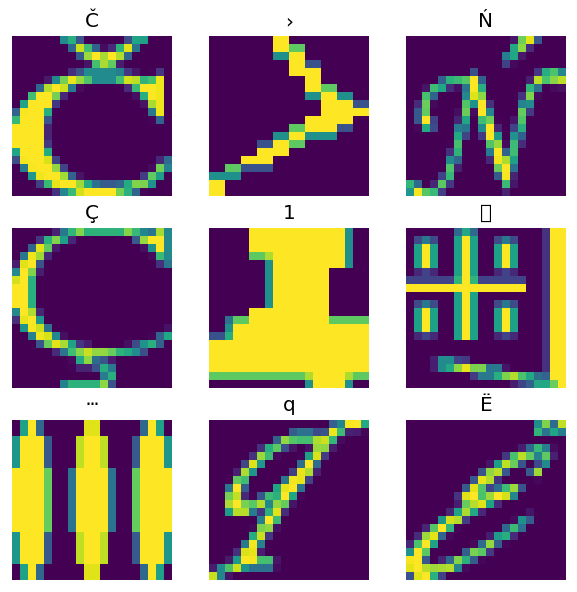

In [49]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6), dpi=120)

for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(features['image'][..., n])
  plt.title(chr(features['m_label'][n]))
  plt.axis('off')